## Introduction
This is an attempt to demonstrate the Smartwatch Segmentation Problem using Python. If you want to download this notebook and run it locally, be sure to grab the data file [here](https://github.com/rainwaterone/smartwatch-segmentation/blob/master/Smartwatch%20Market%20Segmentation%20Case%20Data%20JMP%201_24_2018.csv)

Off-topic - [here](https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/) is an excellent cheat sheet of Jupyter keyboard shortcuts. You don't _have_ to go to _insert/cell below_ to insert a new cell.

## Reading the raw data and assigning to a dataframe
Note that before importing the furnished spreadsheet, I saved it from Excel as a plain .csv file. The `.read_excel()` method in pandas that can, ostensibly, read Excel files, but it seemed to be pulling in some of the file metadata when I read in the `.xlsx` file.

First, we'll import the necessary libraries: pandas, numpy, seaborn, and pyplot. Then we'll read the data into a dataframe called, 'df'.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file = 'Smartwatch Market Segmentation Case Data JMP 1_24_2018.csv'
df = pd.read_csv(file) #This imports the csv file into a dataframe named 'df'

In [2]:
print(df.head()) # Print the first few lines of df

   Variables  Innov  ConstCom  CreatCom  TimelyInf  SaveM_T  SaveM_L  TaskMgm  \
0          1      3         3         5          2        4        4        3   
1          2      5         6         2          6        2        4        6   
2          3      7         7         3          4        2        4        4   
3          4      4         7         4          5        3        3        4   
4          5      7         7         2          4        2        4        2   

   DeviceSt  Photo  ...  Snap  YouTube  Pod_radio  TV  NewsP  AmznP  Age  \
0         3      3  ...     0        0          0   1      0      1   38   
1         6      2  ...     1        1          1   0      1      1   38   
2         4      1  ...     0        1          1   1      1      0   42   
3         5      1  ...     1        1          1   0      1      1   35   
4         6      1  ...     1        1          1   1      1      1   36   

   Female  Degree  Income  
0       1       1       2  


The first column shown in the output is the index of the dataframe. We see that the 'Variables' column of df is already numbered sequentially, so we'll just convert the 'Variables' column to the index. The 'Variables' column will remain column 0, which will be important as we later slice the dataframe into our segmentation and descriptor variables.

In [3]:
df.set_index('Variables')

,Innov,ConstCom,CreatCom,TimelyInf,SaveM_T,SaveM_L,TaskMgm,DeviceSt,Photo,Wellness,...,Snap,YouTube,Pod_radio,TV,NewsP,AmznP,Age,Female,Degree,Income
Variables,,,,,,,,,,,,,,,,,,,,,
1,3,3,5,2,4,4,3,3,3,2,...,0,0,0,1,0,1,38,1,1,2
2,5,6,2,6,2,4,6,6,2,5,...,1,1,1,0,1,1,38,0,2,3
3,7,7,3,4,2,4,4,4,1,6,...,0,1,1,1,1,0,42,0,1,3
4,4,7,4,5,3,3,4,5,1,5,...,1,1,1,0,1,1,35,0,2,5
5,7,7,2,4,2,4,2,6,1,3,...,1,1,1,1,1,1,36,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4,5,4,5,3,5,5,4,3,6,...,0,0,0,1,0,1,37,0,2,4
997,3,7,2,7,2,4,6,5,1,5,...,0,1,1,1,1,1,36,0,1,5
998,4,5,2,6,2,4,7,7,2,4,...,0,1,1,1,0,1,40,0,1,5


Since for the segmentation, we are only interested in the segmentation variables, which are in the columns 'Innov' thru 'Price', I'll read those into a separate dataframe named 'dfSeg' using the `.iloc()` method. 

In [4]:
dfSeg = df.loc[:,'Innov':'Price']

Note that the first parameter of the `.iloc()` method specifies the range of rows to be included, in the form `firstrow:lastrow`. Since we want all rows, we simply leave the colon `:` in place and specify only the columns we want.

Now, we'll print the first few rows of the new `dfSeg` dataframe:

In [5]:
print(dfSeg.head())

   Innov  ConstCom  CreatCom  TimelyInf  SaveM_T  SaveM_L  TaskMgm  DeviceSt  \
0      3         3         5          2        4        4        3         3   
1      5         6         2          6        2        4        6         6   
2      7         7         3          4        2        4        4         4   
3      4         7         4          5        3        3        4         5   
4      7         7         2          4        2        4        2         6   

   Photo  Wellness  Athlete  Style  Price  
0      3         2        3      3    200  
1      2         5        3      1    350  
2      1         6        4      1    220  
3      1         5        4      4    320  
4      1         3        2      4    250  


Just for giggles, we'll plot a histogram of the Innov preference values using Seaborn:

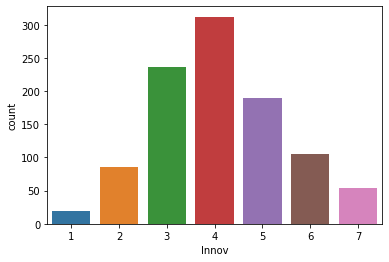

In [6]:
sns.countplot(x = 'Innov', data = dfSeg)

## Setting up the segmentation and creating the dendrogram
Now, we'll get into the fun stuff of doing the segmentation. The fancy plot that we created in JMP is called a dendrogram. It is generated by a function in SciPy called, accordingly, `dendrogram()` that is part of the scipy.cluster.hierarchy group of functions. 

Before creating the dendrogram, we have to actually perform the hierarchial clustering, which is done with the `linkage()` function. Below, we will:
1. Import the functions (Normally, I would do this at the very beginning, but I do it now to call attention to it.)
2. Call `linkage()` on our `dfSeg` dataframe using the Ward variance minimization algorithm
3. Set the size and title for our plot
4. Call `dendrogram()` to generate the dendrogram
5. Assign it all to a variable `dend`, which will plot it.

This takes a while to run on my used-to-be-considered-fast Xeon CADstation, so be patient.

There is much more information at the [SciPy Documentation Page](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html)

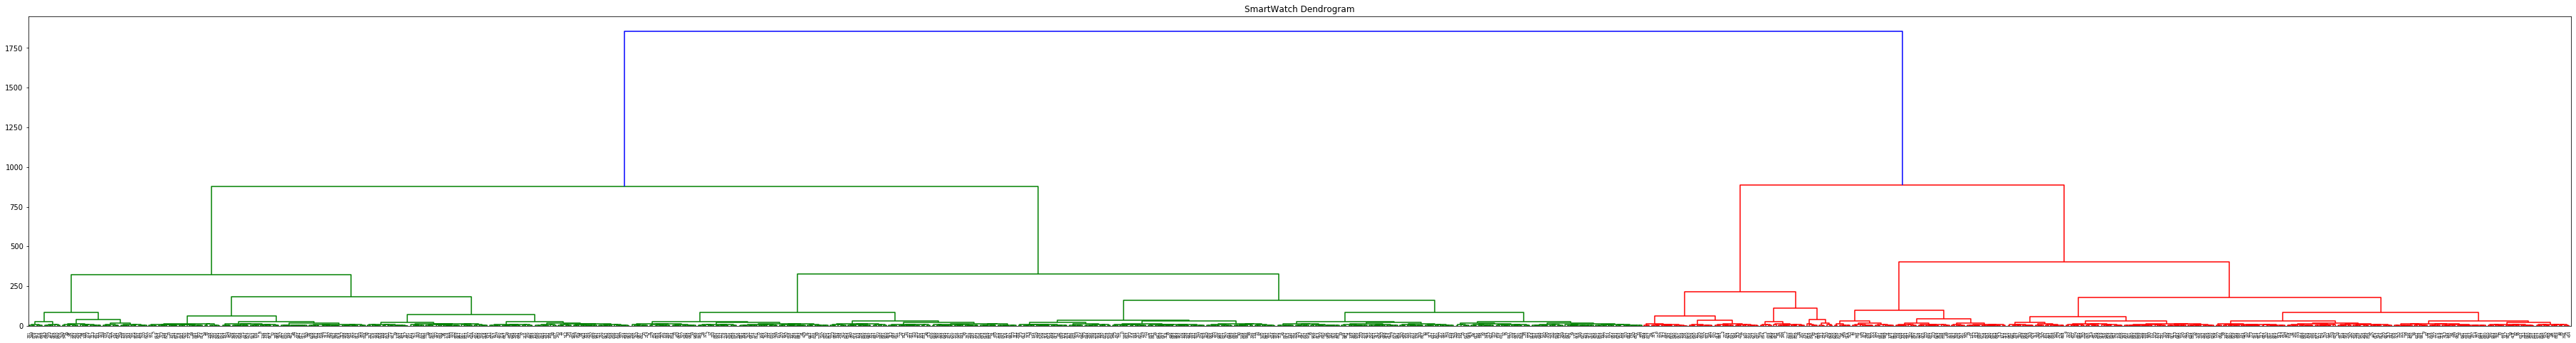

In [7]:
import scipy.cluster.hierarchy as sch # I called it 'sch' for 'SciPy Cluster Hierarchy. You can call it whatever.'
from scipy.spatial.distance import pdist # This will be used for computing distance between clusters

linkmat = sch.linkage(dfSeg, method='ward') # Generates the linkage matrix

plt.rcParams["figure.figsize"] = (64,8) # This sets the size of the plot
plt.title('SmartWatch Dendrogram') # This sets the title for the plot
dend = sch.dendrogram(linkmat) #This assigns the plot object to the variable 'dend', and plots it

Next, we'll generage the cophenetic correlation coefficient. This is a measure of how well a dendrogram preserves the pairwise distances between the data points. Like most things in statistics and data science, there is no standard for what constitutes a 'good' value; it's primarily relevant when comparing with other similar segmentations.

In [8]:
c, coph_dists = sch.cophenet(linkmat, pdist(dfSeg)) # Generates the Cophenetic Correlation Coefficient
print(c)

0.6252394440172576


In the dendrogram, the _x_-axis contains the segmentation variables, and the _y_-axis represents the distance between the clusters. 

Suppose we want to segment into 4 clusters...We can regenerate the plot above with a horizontal line at 500 to see how this will look. The following code does that:

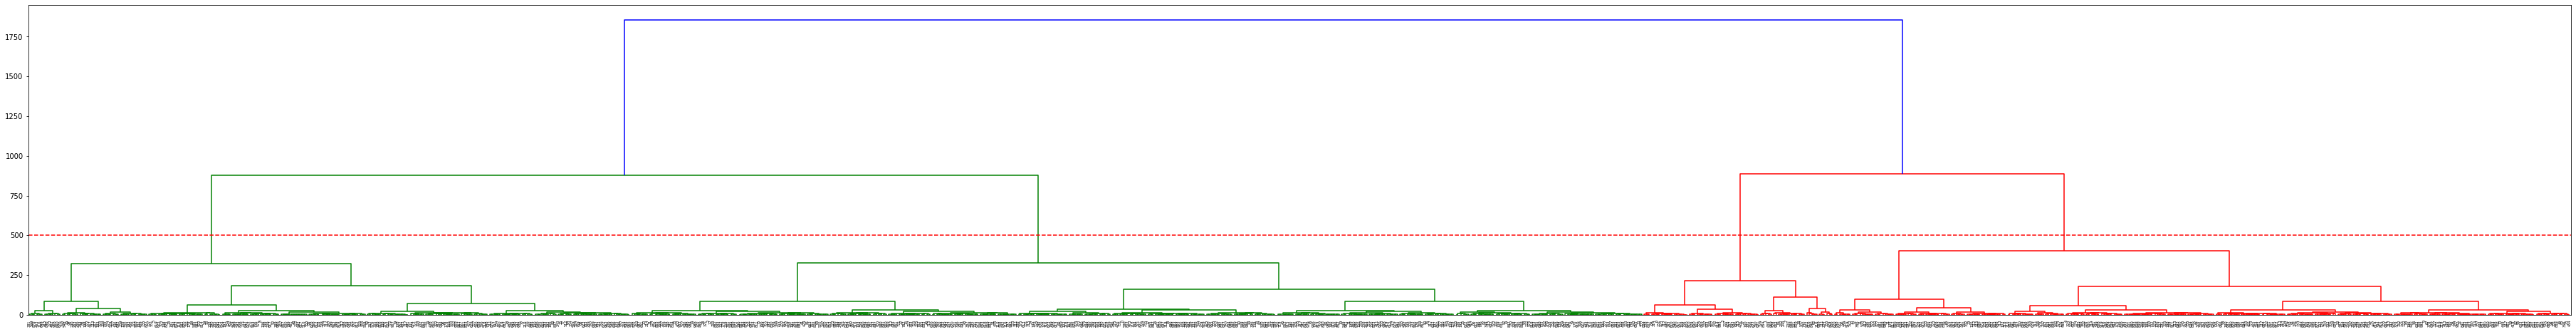

In [9]:
#plt.rcParams["figure.figsize"] = (64,8)
#plt.title('SmartWatch Dendrogram') # This sets the title for the next plot
dend = sch.dendrogram(sch.linkage(dfSeg,method='ward'))
plt.axhline(y=500, color = 'red', linestyle = '--')

## Performing the segmentation
Note that this only drew a dashed line across our graph, it did not actually segment our data. To to that, we'll need to import a function from sklearn. The following code imports the function, then segments the data into 4 clusters using Euclidean distance to form the clusters, using Ward's method to minimize the variance within each cluster.

The last two lines of this section of code will output the results of the clustering as a 1 x _n_ array in which the _n_th- value represents the predicted cluster for the _n_th customer.

In [10]:
from sklearn.cluster import AgglomerativeClustering # Again, I would normally do this at the beginning of the file
myCluster = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward') # sets up the clustering params
y_hc = myCluster.fit_predict(dfSeg) # This line creates a map of the cluster as an array
print(y_hc) # This prints a list of the assigned segment for each customer

[1 2 1 2 0 3 2 2 3 0 0 0 1 1 1 1 0 1 3 1 1 0 1 0 3 1 1 2 1 0 1 1 0 1 1 3 1
 3 2 1 1 1 0 1 1 1 1 0 3 3 1 1 3 0 3 3 0 1 0 0 1 2 2 1 3 0 1 0 3 2 0 1 0 3
 1 1 1 3 1 3 1 1 1 0 3 0 3 0 3 0 0 0 3 3 1 0 3 1 3 0 3 3 1 1 0 3 0 0 3 1 1
 2 0 3 0 1 3 0 3 3 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 3 3 2 1 1 1 3 2 1 0 0 3 1
 3 0 1 1 0 1 3 1 3 0 3 2 2 2 0 0 0 0 3 1 1 3 1 3 0 1 0 1 0 0 3 3 0 3 3 3 1
 0 1 1 3 1 1 1 0 3 1 1 0 1 3 1 2 2 3 1 2 1 3 0 1 3 3 1 3 0 1 1 2 3 1 0 1 1
 3 0 1 2 1 3 0 1 0 3 2 1 3 1 1 2 3 0 1 1 1 3 2 2 0 0 1 3 1 2 3 1 3 0 0 1 1
 1 0 1 0 3 3 0 0 3 1 1 3 3 3 3 3 1 1 1 1 1 1 1 2 3 1 3 3 2 1 3 3 0 3 3 3 1
 1 1 1 3 0 1 0 3 1 1 1 1 2 3 1 0 1 0 2 2 1 1 0 1 3 1 1 3 0 0 0 3 1 1 3 0 0
 1 3 1 0 0 0 0 1 0 0 3 1 1 0 0 1 1 1 1 1 0 3 2 0 1 1 0 2 1 0 1 0 3 3 3 0 1
 0 1 3 3 3 1 3 1 0 0 1 3 3 1 1 0 0 1 1 3 3 1 3 1 0 0 1 0 3 0 0 0 0 3 1 0 1
 1 3 3 1 1 0 0 1 3 0 1 0 1 1 1 3 2 1 1 2 3 0 3 0 0 1 1 1 1 1 3 1 2 3 0 0 0
 1 1 0 0 0 0 3 1 3 1 0 3 2 3 1 0 3 3 3 3 1 0 1 3 0 1 1 3 1 1 1 1 1 0 2 2 1
 0 3 0 0 1 1 0 0 1 2 3 1 

Now, we'll graft the cluster vector onto dfSeg as a column names 'segment'. We'll do likewise with df in case we decide to use it later...

In [11]:
dfSeg = dfSeg.assign(segment=pd.Series(y_hc).values)
df = df.assign(segment=pd.Series(y_hc).values)

In [12]:
print(dfSeg.head())

   Innov  ConstCom  CreatCom  TimelyInf  SaveM_T  SaveM_L  TaskMgm  DeviceSt  \
0      3         3         5          2        4        4        3         3   
1      5         6         2          6        2        4        6         6   
2      7         7         3          4        2        4        4         4   
3      4         7         4          5        3        3        4         5   
4      7         7         2          4        2        4        2         6   

   Photo  Wellness  Athlete  Style  Price  segment  
0      3         2        3      3    200        1  
1      2         5        3      1    350        2  
2      1         6        4      1    220        1  
3      1         5        4      4    320        2  
4      1         3        2      4    250        0  


Now, we can construct a table of the means of the basis variables for each segment. Amazingly, the .pivot_table() function of Pandas does that, and its default aggregation is the mean of each column for each index value...so, selecting 'segment' as the index:

In [13]:
pd.pivot_table(dfSeg, index="segment")

,Athlete,ConstCom,CreatCom,DeviceSt,Innov,Photo,Price,SaveM_L,SaveM_T,Style,TaskMgm,TimelyInf,Wellness
segment,,,,,,,,,,,,,
0,3.989655,5.106897,4.324138,3.900000,4.437931,3.062069,250.896552,4.127586,3.441379,4.844828,4.620690,4.437931,4.993103
1,3.798995,4.575377,4.271357,3.831658,4.077889,3.160804,200.402010,3.942211,3.484925,4.180905,4.158291,4.256281,4.341709
2,2.773333,5.640000,2.746667,5.253333,4.480000,2.000000,332.133333,3.960000,2.226667,3.800000,5.373333,5.626667,3.906667
3,3.953586,4.071730,4.641350,3.333333,3.594937,3.649789,149.535865,3.869198,3.801688,3.987342,3.341772,3.742616,3.789030


While the index numbers are not in the same order as the [JMP output presented in class](https://docs.google.com/presentation/d/1EaKxI7HpHt0JmTvZBX407RY3_ohcSr-XM-9wpy91G5Y/edit#slide=id.p6), you can match them up by looking at the mean of any one column. For example, the mean Price for our segment = 0 matches with Segment 4 of Dr. Hari's solution. Similarly, we can see that our other results match that in the solution. As a cross reference, I'll set up a table that shows which of these segments correspond with Dr. Hari's:

In [14]:
xref = [[0, 4],[1,1], [2,3],[3,2]] # Create a list  of the ordered pairs
cross_reference = pd.DataFrame(xref,columns = ['this_case', 'Dr_Hari']) # Put them in a dataframe for easy viewing
print(cross_reference)

   this_case  Dr_Hari
0          0        4
1          1        1
2          2        3
3          3        2


I don't really plan to do anything with cross_reference, it's just there to easily relate our output to Dr. Hari's solution.

## Feature selection

Next, we'll attempt to actually perform a fit with the data to select the four factors which most influence the segmentation. SelectKBest will select the best _k_ factors (features) based upon whatever scoring function we choose. We'll select the four with the best chi-squared values.

We'll start by creating an input dataframe containing the input (explanatory) variables and the output (segmentation) value:

In [15]:
X = dfSeg.iloc[:,0:12] # Creates an input dataframe of all rows and the first 12 columns of dfSeg
Y = dfSeg.iloc[:,-1]   # Creates a target dataframe containing the segment column (-1 denotes the last column)

Now, we'll import SelectKBest and chi2 from scikit-learn. Again, I'll normally import these at the beginning, but I put them here so that you can better associate them with their task.

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k=4) # Sets up an object for which we'll use chi^2 scores to select the top 4 fits
fit = test.fit(X,Y) # Actually perform the fit to find the factors that most impact the segment assignment

np.set_printoptions(precision=3) # Optionally, limit the print precision to make display neater
print(fit.scores_) # Print the fit scores

[25.523 45.611 48.703 49.373 41.139  2.469 78.695 55.137 50.793 47.859
 24.877 31.087]


The top four scores are associated with Column 6, 7, 8, and 3 (remembering that the first column is Column 0). Optionally, I'll do some dataframe magic to make the results more comprehensible:

In [17]:
df_scores = pd.DataFrame(fit.scores_) # Create a dataframe with the fit scores
df_columns = pd.DataFrame(X.columns)  # Create a dataframe with the column headings
feature_scores = pd.concat([df_columns,df_scores], axis=1) # Concatenate the two into one
feature_scores.columns = ['Feature', 'Score'] # This will create column headings
print(feature_scores.nlargest(4,'Score')) # Prints the four best features

     Feature      Score
6    TaskMgm  78.695317
7   DeviceSt  55.136865
8      Photo  50.792537
3  TimelyInf  49.373357


## Conclusion
Hopefully, this will provide you with some context on how to perform a segmentation in Python. It looks intimidating when compared to the JMP UI, but gives you an invaluable jumping-off (no pun intended) point into using Python for serious data science. I encourage you to try this with other datasets; there are many other segmentation or clustering examples available via an internet search.

## References
[https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/](https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/)

[https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318](https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318)

[https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6)

[https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb](https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb)

[https://hub.packtpub.com/4-ways-implement-feature-selection-python-machine-learning/](https://hub.packtpub.com/4-ways-implement-feature-selection-python-machine-learning/)